```markdown
## Transitioning to vision
```

```markdown
## datasets
## dataloaders
## transforms
## custom datasets  and dataloaders
```

In [1]:
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

In [2]:
## lets' get fashion mnist dataset

# Setup training data
train_data = datasets.FashionMNIST(
                                root="data", # where to download data to?
                                train=True, # get training data
                                download=True, # download data if it doesn't exist on disk
                                transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
                                target_transform=None # you can transform labels as well
                                )

# Setup testing data
test_data = datasets.FashionMNIST(
                                root="data",
                                train=False, # get test data
                                download=True,
                                transform=ToTensor()
                                )

In [3]:
# know your dataset
print("train_data: ", train_data.data.shape)
print("test_data: ", test_data.data.shape)

# know your dataset
print("train_target: ", train_data.targets.shape)
print("test_target: ", test_data.targets.shape)

# classes in the dataset
print("Classes: ", train_data.classes)

train_data:  torch.Size([60000, 28, 28])
test_data:  torch.Size([10000, 28, 28])
train_target:  torch.Size([60000])
test_target:  torch.Size([10000])
Classes:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



| PyTorch module | What does it do? |
| ----- | ----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Contains datasets, model architectures and image transformations common for computer vision. |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | various vision datasets for tasks  i.e  classification, detection, captioning, video classification and more. |
| [`torchvision.models`](https://pytorch.org/vision/stable/models.html) | Contains well-performing and commonly used computer vision model architectures implemented in PyTorch. | 
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | common image transformations.images need to be transformed before fed to models. | 
| [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) | Base dataset class for PyTorch.  | 
| [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Creates a Python iterable over a dataset (created with `torch.utils.data.Dataset`). |


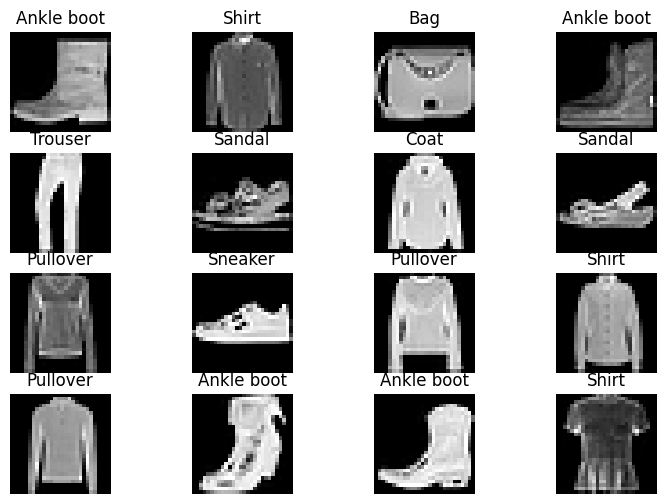

In [4]:
#sample image a
torch.manual_seed(42)
fig = plt.figure(figsize=(9,6))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False);

In [5]:
## dataloader

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [6]:
"""Model"""
import torch.nn as nn

class FModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
""" Training Loop"""
epochs = 10
device = "cpu"

#model
model = FModel(input_shape=784, # one for every pixel (28x28)
                hidden_units=10, 
                output_shape=len(train_data.classes) 
            ).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)


for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n------")
    ## train step
    
    epoch_train_acc = 0
    epoch_train_loss = 0
    for batch in train_dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        
        # forward pass
        y_logits = model(x)
        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y, torch.softmax(y_logits, dim=1).argmax(dim=1))
        
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        epoch_train_acc += acc
    
    epoch_train_loss /= len(train_dataloader)
    epoch_train_acc /= len(train_dataloader)
    
    ## test step
    with torch.no_grad():
        epoch_test_loss = 0
        epoch_test_acc = 0
        for batch in test_dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            
            y_test_logits = model(x)
            test_loss = loss_fn(y_test_logits, y)
            test_acc = accuracy_fn(y, torch.softmax(y_test_logits, dim=1).argmax(dim=1))
            
            epoch_test_acc += test_acc
            epoch_test_loss += test_loss.item()
    
        epoch_test_loss /= len(test_dataloader)
        epoch_test_acc /= len(test_dataloader)
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")


**Train Test Steps functions**


In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")